In [1]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
%matplotlib inline

# settings
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    
    jitterTolerance=1.0,
    barnesHutOptimize=True, 
    barnesHutTheta=1.2, 
    multiThreaded=False,
    
    scalingRatio=1.0, 
    strongGravityMode=True, 
    gravity=.5,
    
    # Log
    verbose=True)

In [2]:
import networkx as nx
import numpy as np
import pandas as pd

In [17]:
G = nx.random_partition_graph([22,15,18], .6, .05)

In [18]:
pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations =500)

100%|██████████| 500/500 [00:00<00:00, 10148.18it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


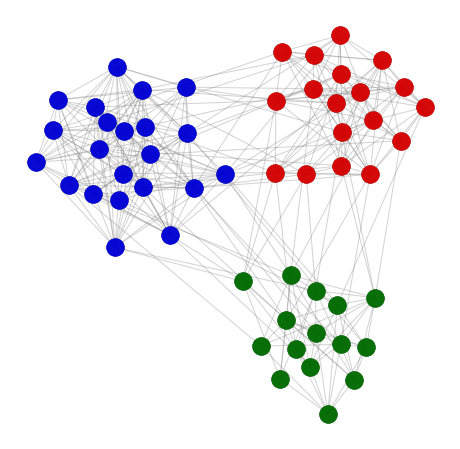

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos,
                       node_color = 'black', 
                       alpha=0.8)
nx.draw_networkx_nodes(G, pos,
                       nodelist= range(22),
                       node_color = 'blue', 
                       alpha=0.8)
nx.draw_networkx_nodes(G, pos,
                       nodelist= range(22,37),
                       node_color = 'green', 
                       alpha=0.8)
nx.draw_networkx_nodes(G, pos,
                       nodelist= range(37,55),
                       node_color = 'red', 
                       alpha=0.8)

nx.draw_networkx_edges(G, pos, edge_color="grey", alpha=0.35)


#nx.draw_networkx_labels(G_fb, pos, labels=labels, font_size=12, font_color='orange')
plt.axis('off');

In [ ]:
#### len(G.nodes())

In [1993]:
import random
random_nodes1 = random.sample(range(len(G.nodes())),int(len(G.nodes())*.02))

In [1994]:
bipartite_node = random_nodes1

In [2038]:
edge_list = list(zip(*list(zip(*nx.to_edgelist(G)))[:2]))

In [2039]:
edge_list = pd.DataFrame(edge_list, columns=['Source','Target'])
edge_list2 = edge_list[['Target','Source']].rename(columns={'Target':'Source','Source':'Target'})
edge_list = pd.concat([edge_list, edge_list2], axis=0)
edge_list = edge_list[[source not in bipartite_node for source in edge_list.Source ]]
bipartite_net = pd.merge(edge_list, pd.DataFrame(bipartite_node, columns=['Target']))

In [2040]:
user_nodes = list(set(bipartite_net.Source))

In [2041]:
edge_list3 = pd.merge(edge_list2, pd.DataFrame(user_nodes,columns=['Target']))
user_net = pd.merge(edge_list3, pd.DataFrame(user_nodes,columns=['Source']))

In [2042]:
bipartite_graph = nx.from_pandas_edgelist(bipartite_net, 'Source', 'Target', create_using=nx.DiGraph())
user_graph = nx.from_pandas_edgelist(user_net, 'Source', 'Target', create_using=nx.Graph())

In [2043]:
bipartite_nodes_order = np.array(bipartite_graph.nodes())
bipartite_adj = nx.adjacency_matrix(bipartite_graph, bipartite_nodes_order)

In [2044]:
rowsum = bipartite_adj.sum(axis=1)
colsum = bipartite_adj.sum(axis=0)
filter_row = rowsum>0
filter_row= np.array(filter_row).reshape((filter_row.shape[0],))
filter_col = colsum>0
filter_col = np.array(filter_col).reshape(((filter_col.shape[1]),))
bipartite_adj = bipartite_adj[:,filter_col]
bipartite_adj = bipartite_adj[filter_row,]

In [2045]:
bipartite_adj.shape

(1069, 22)

In [2046]:
# rows :users
bipartite_nodes_order_row = bipartite_nodes_order[filter_row]
# cols: targets
bipartite_nodes_order_col = bipartite_nodes_order[filter_col]

In [2079]:
len(bipartite_nodes_order_row)

221

In [2048]:
user_fitlter = (bipartite_adj.sum(axis=1).A.reshape(1,-1)>4)[0]
bipartite_adj2 = bipartite_adj[user_fitlter,:]
# rows :users
bipartite_nodes_order_row = bipartite_nodes_order_row[user_fitlter]

In [2049]:
user_adj = nx.adjacency_matrix(user_graph, bipartite_nodes_order_row)

In [2050]:
def calculate_denum(target_node_index, sum_node_edge, target_neighbor_node_sim_mat, target_neighbor_sim_mat,bipartite_adj):
    if target_node_index%500==0:
        print(target_node_index)
    return csr_matrix(sum_node_edge[target_node_index]*sum_node_edge.T*(target_neighbor_sim_mat[target_node_index,:]>0).A)

def num_edge_in_egonet_among_neighbors(target_node_index, bipartite_adj, general_adj):
    if target_node_index%500==0:
        print(target_node_index)
    # Find neighbors : Binary array with the same length of sources
    neighbors = bipartite_adj.T[target_node_index,:].nonzero()[1]
    
    # Return the sum of edges in the general network.
    # Divide by two as they appear in the adjacency matrix 2 times
    # It is always an integer
    return np.int(np.sum(general_adj[:,neighbors][neighbors,])/2)

def target_ego_edge_similarity_2(target_node_index, bipartite_adj, general_adj):
    if target_node_index%500==0:
        print(target_node_index)
    # Find the similarity of edge in ego network of target_index and all other targets
    ego_net_edge_similarty = (np.sum(bipartite_adj.T.multiply((bipartite_adj.T[target_node_index,:].A>0)[0]).dot(general_adj).multiply(bipartite_adj.T.multiply((bipartite_adj.T[target_node_index,:].A>0)[0])),axis=1).T / 2).astype(int)
    return csr_matrix(ego_net_edge_similarty)

def target_ego_edge_similarity(target_node_index, bipartite_adj, general_adj):
    if target_node_index%500==0:
        print(target_node_index)
    temp = bipartite_adj.copy()
    temp = scipy.sparse.csc_matrix(temp)
    # temp[:,target_node_index].A : who are the followers in of target_index
    temp.data += np.take(temp[:,target_node_index].A, temp.indices)
    # Find the similarity of edge in ego network of target_index and all other targets
    ego_net_edge_similarty = (np.sum((temp == 2).T.dot(general_adj).multiply((temp == 2).T),axis=1).T / 2).astype(int)
    return csr_matrix(ego_net_edge_similarty)

def find_SimMat_for_Targets(bipartite_adj, general_adj, agents = 2, chunksize =3):
    target_neighbors_node_count_vector = np.array(bipartite_adj.sum(axis=0)).reshape(-1)

    with Pool(processes = agents) as pool:
        # prepare the num_edge_in_egonet_among_neighbors for accepting several inputs, only one change
        pool_function = partial(num_edge_in_egonet_among_neighbors, bipartite_adj = bipartite_adj, general_adj =general_adj )
        # bipartite_adj.shape[1] is the number of targets
        res = pool.map(pool_function,range(bipartite_adj.shape[1]), chunksize)
    target_neighbors_edge_count_vector = np.array(res)
    del res
    
    # number of common friends (node)
    target_neighbor_node_sim_mat = bipartite_adj.T.dot(bipartite_adj)
    target_neighbor_node_sim_mat = target_neighbor_node_sim_mat.tocsr()
    
    # Create the matrix of edge similarity among neighbors of targets
    target_neighbor_edge_sim_mat = csr_matrix((bipartite_adj.shape[1],bipartite_adj.shape[1]), dtype=int)
    target_neighbor_edge_sim_mat = target_neighbor_edge_sim_mat.tolil()
    with Pool(processes = agents) as pool:
        # prepare the target_ego_edge_similarity for accepting several inputs, only one change
        pool_function = partial(target_ego_edge_similarity, bipartite_adj = bipartite_adj, general_adj =general_adj )
        # bipartite_adj.shape[1] is the number of targets
        res = pool.map(pool_function,range(bipartite_adj.shape[1]), chunksize)
    
    for index, item in enumerate(res):
        if index%500==0:
            print(index)
        target_neighbor_edge_sim_mat[index,:] = item
    del res
    target_neighbor_edge_sim_mat = target_neighbor_edge_sim_mat.tocsr()
    
    
    # simlifying
    target_neighbor_sim_mat = target_neighbor_node_sim_mat + target_neighbor_edge_sim_mat
    sum_node_edge = target_neighbors_node_count_vector + target_neighbors_edge_count_vector
    sum_node_edge = sum_node_edge.reshape(-1,1)

    denum = sum_node_edge.dot(sum_node_edge.T)
    denum[target_neighbor_sim_mat.A == 0] = 0
    denum = csr_matrix(denum)
    
    
    # let's use the log version of the similarity
    denum_log_data = np.log(denum.data)
    target_neighbor_sim_mat.data = 2 * np.log(target_neighbor_sim_mat.data) - denum_log_data
    target_neighbor_sim_mat.data = np.exp(target_neighbor_sim_mat.data)
    
    # target_neighbor_sim_mat becomes the overall similarity
    return target_neighbor_sim_mat

In [2051]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy
from scipy.sparse import csr_matrix
from multiprocessing import Pool
from functools import partial

In [2052]:
sim_mat = find_SimMat_for_Targets(bipartite_adj2, user_adj, agents = 2, chunksize =10)

0
0
0


In [2053]:
weights = sim_mat.A.sum(axis=1)-1

In [2054]:
def cluster_method(i):
    if i%200==0:
        print(i)
    partition = louvain.find_partition(g, louvain.SurpriseVertexPartition, weights='weight');
    return (i,partition.quality(), partition.membership)

In [2055]:
import louvain
import igraph as ig

sim_mat = sim_mat.tolil()
sim_mat.setdiag(0) 

A = sim_mat.A
g = ig.Graph.Adjacency((A > 0).tolist())
g.es['weight'] = A[A.nonzero()]
g.vs['label'] = bipartite_nodes_order_col

In [2056]:
quality = 0
quyalityList = []
partitionList = []
for i in range(50):
    partition = louvain.find_partition(g, louvain.SurpriseVertexPartition, weights='weight');
    quyalityList.append(partition.quality())
    partitionList.append(partition.membership)
    print("Loop {}: Quality = {}".format(i,partition.quality()))
    if partition.quality() > quality:
        quality = partition.quality()
        bestPartition = partition
        print("Imporved")

Loop 0: Quality = 2.095646791165931
Imporved
Loop 1: Quality = 2.095646791165931
Loop 2: Quality = 2.095646791165931
Loop 3: Quality = 2.095646791165931
Loop 4: Quality = 2.095646791165931
Loop 5: Quality = 2.0864247676086967
Loop 6: Quality = 2.095646791165931
Loop 7: Quality = 2.095646791165931
Loop 8: Quality = 2.095646791165931
Loop 9: Quality = 2.095646791165931
Loop 10: Quality = 2.0864247676086967
Loop 11: Quality = 2.095646791165931
Loop 12: Quality = 2.095646791165931
Loop 13: Quality = 2.095646791165931
Loop 14: Quality = 2.095646791165931
Loop 15: Quality = 2.095646791165931
Loop 16: Quality = 2.095646791165931
Loop 17: Quality = 2.095646791165931
Loop 18: Quality = 2.095646791165931
Loop 19: Quality = 2.0864247676086967
Loop 20: Quality = 2.095646791165931
Loop 21: Quality = 2.095646791165931
Loop 22: Quality = 2.095646791165931
Loop 23: Quality = 2.095646791165931
Loop 24: Quality = 2.095646791165931
Loop 25: Quality = 2.0864247676086967
Loop 26: Quality = 2.09564679116593

In [2057]:
dat = pd.DataFrame(np.array([bipartite_nodes_order_col,np.array(partitionList[0]),weights]).T, columns=['Members','Cluster','weights']) 
dat.head()

,Members,Cluster,weights
0,111.0,10.0,0.184086
1,352.0,0.0,0.430367
2,402.0,0.0,0.432938
3,626.0,5.0,0.179298
4,26.0,9.0,0.172755


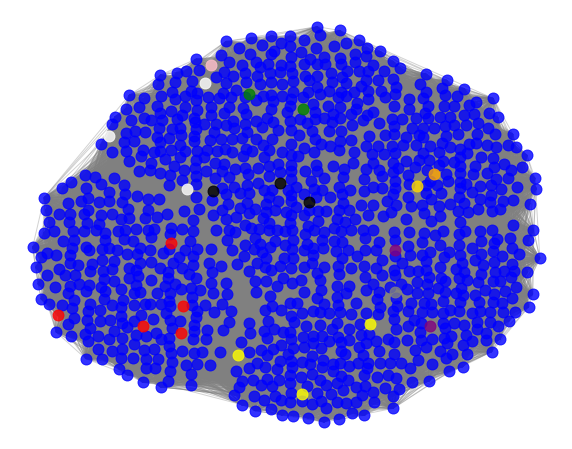

In [2058]:
colors={0:'red', 1:'black',2:'white', 3:'yellow',4:'green',5:'pink',6:'grey',7:'orange',8:'gold', 9:'purple', 10:'purple', 11:'purple'}

fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos,
                       nodelist= set(list(G.nodes)) - set(dat.Members),
                       node_size = 120, 
                       node_color = 'Blue', 
                       alpha=0.8)

cluster_size = len(set(dat.Cluster))

for cluster in range(cluster_size):
    nodes = list(dat[dat.Cluster==cluster].Members)
    nx.draw_networkx_nodes(G, pos,
                       nodelist= nodes,
                       node_size = 120, 
                       node_color = colors[cluster], 
                       alpha=0.8)



nx.draw_networkx_edges(G, pos, edge_color="grey", alpha=0.35)

#labels = {hub:hub for hub in hubs}
#nx.draw_networkx_labels(G, pos, font_size=17, font_color='black')

#labels = {outlier:outlier for outlier in outliers}
#nx.draw_networkx_labels(G_fb, pos, labels=labels, font_size=12, font_color='orange')
plt.axis('off');

In [2059]:
clusterMat = np.zeros((cluster_size,len(dat.Cluster)))
for i in range(cluster_size):
    mask = (dat.Cluster == i)
    clusterMat[i,mask] = 1/dat.weights[mask]

In [2060]:
clusterMat.shape

(11, 22)

In [2061]:
# A = (clusterMat/clusterMat.sum(axis=1,keepdims=True)).dot(sim_mat.A)
# B = ((1-clusterMat)/((1-clusterMat).sum(axis=1,keepdims=True))).dot(sim_mat.A)
# clusterMat = (A/B) * clusterMat

In [2062]:
colnames_embedding = list()
for i in range(cluster_size) :
    name = "E"+str(i)
    colnames_embedding.append(name)

In [2063]:
sumWeights = clusterMat.sum(axis=1,keepdims=True)
#normalize
cluster_mat = clusterMat / sumWeights

In [2064]:
new_bipartite_adj = nx.adjacency_matrix(G, range(len(G.nodes)))
new_bipartite_adj = new_bipartite_adj.tolil()
new_bipartite_adj.setdiag(1)

In [2065]:
new_bipartite_adj = new_bipartite_adj[:,bipartite_nodes_order_col]

In [2066]:
new_bipartite_adj.shape

(1130, 22)

In [2067]:
cluster_mat.shape

(11, 22)

In [2068]:
user_embedding = new_bipartite_adj.dot(cluster_mat.T)
#user_embedding = pd.DataFrame(user_embedding, index=range(len(G.nodes)), columns=colnames_embedding)

In [2069]:
adj = nx.adjacency_matrix(G, range(len(G.nodes)))
user_embedding = adj.dot(user_embedding)/adj.sum(axis=1)
user_embedding = pd.DataFrame(user_embedding, index=range(len(G.nodes)), columns=colnames_embedding)

In [2070]:
user_embedding = pd.DataFrame(user_embedding, index=range(len(G.nodes)), columns=colnames_embedding)
user_embedding.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10
0,0.171824,0.151445,0.113818,0.114185,0.112208,0.093168,0.167702,0.086957,0.173913,0.211180,0.136646
1,0.117798,0.099780,0.113264,0.117885,0.127715,0.094595,0.182432,0.148649,0.114865,0.229730,0.202703
2,0.156902,0.135266,0.121365,0.115581,0.136054,0.108844,0.190476,0.142857,0.122449,0.251701,0.190476
3,0.155759,0.147942,0.111093,0.111975,0.138524,0.123529,0.164706,0.129412,0.105882,0.247059,0.205882
4,0.155899,0.090198,0.125585,0.133739,0.142926,0.059603,0.251656,0.119205,0.112583,0.264901,0.192053


In [2071]:
user_embedding = user_embedding.reset_index()

In [2072]:
user_embedding.head()

,index,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10
0,0,0.171824,0.151445,0.113818,0.114185,0.112208,0.093168,0.167702,0.086957,0.173913,0.211180,0.136646
1,1,0.117798,0.099780,0.113264,0.117885,0.127715,0.094595,0.182432,0.148649,0.114865,0.229730,0.202703
2,2,0.156902,0.135266,0.121365,0.115581,0.136054,0.108844,0.190476,0.142857,0.122449,0.251701,0.190476
3,3,0.155759,0.147942,0.111093,0.111975,0.138524,0.123529,0.164706,0.129412,0.105882,0.247059,0.205882
4,4,0.155899,0.090198,0.125585,0.133739,0.142926,0.059603,0.251656,0.119205,0.112583,0.264901,0.192053


In [2073]:
X = user_embedding.drop('index',axis=1)

In [2074]:
X.shape

(1130, 11)

In [2075]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=7, random_state=0)
kmeans_model.fit(X)
y_kmeans = kmeans_model.predict(X)

In [2076]:
clustering_result = pd.DataFrame(np.array([np.array(range(len(G.nodes))), y_kmeans]).T, columns=['member','cluster'])

In [2077]:
clustering_result.head()

,member,cluster
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


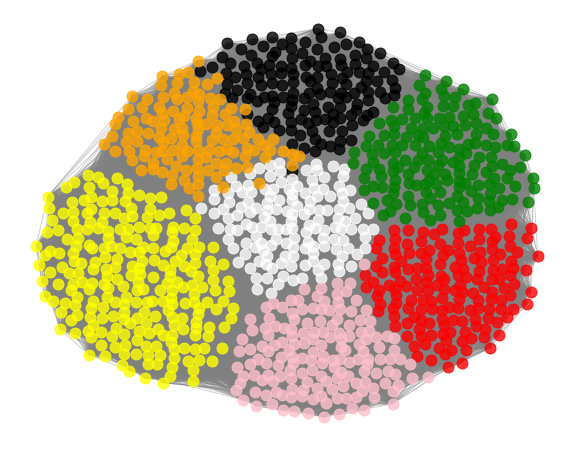

In [2078]:
colors={0:'red', 1:'black',2:'white', 3:'yellow',4:'green',5:'pink',6:'orange'}

fig, ax = plt.subplots(figsize=(10, 8))

cluster_size = len(set(dat.Cluster))

for cluster in range(7):
    nodes = list(clustering_result[clustering_result.cluster==cluster].member)
    nx.draw_networkx_nodes(G, pos,
                       nodelist= nodes,
                       node_size = 120, 
                       node_color = colors[cluster], 
                       alpha=0.8)



nx.draw_networkx_edges(G, pos, edge_color="grey", alpha=0.35)
plt.axis('off');